# Model 1: DenseNet121 ile Transfer Learning Tabanlı Sınıflandırma


In [ ]:

from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications.densenet import DenseNet121, preprocess_input
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import (
    accuracy_score, balanced_accuracy_score, matthews_corrcoef,
    precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_curve, auc
)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from itertools import cycle

## 1. Veri Seti ve Ön İşleme Süreci

Bu çalışmada görüntü sınıflandırma problemi için **DenseNet121** tabanlı bir
Transfer Learning modeli kullanılmıştır.

Veri seti üç alt kümeye ayrılmıştır:
- **Train (Eğitim)**
- **Validation (Doğrulama)**
- **Test**

Eğitim verisi üzerinde veri artırma (data augmentation) uygulanarak
modelin genelleme yeteneği artırılmıştır. Tüm görüntüler DenseNet mimarisine
uygun olacak şekilde normalize edilmiştir.


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 16
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_CLASSES = 5

TRAIN_DIR = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/train"
VAL_DIR   = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/val"
TEST_DIR  = "/content/drive/MyDrive/Sugarcane Disease/dataset_split/test"

OUTPUT_DIR = f"/content/drive/MyDrive/DenseNet121_Results_Update2"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ---- DATASETS ----
train_augment = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.15)
])

train_ds = image_dataset_from_directory(TRAIN_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=True)
val_ds   = image_dataset_from_directory(VAL_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)
test_ds  = image_dataset_from_directory(TEST_DIR, image_size=IMG_SIZE, batch_size=BATCH_SIZE, shuffle=False)

class_names = train_ds.class_names

def preprocess(images, labels):
    images = train_augment(images)
    return preprocess_input(images), labels

train_ds = train_ds.map(preprocess)
val_ds   = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds  = test_ds.map(lambda x, y: (preprocess_input(x), y))

## 2. Model Mimarisi

DenseNet121 modeli, ImageNet veri seti üzerinde önceden eğitilmiş ağırlıklar ile
kullanılmıştır. Özellik çıkarıcı katmanlar dondurulmuş ve sınıflandırma için
özel olarak tasarlanmış tam bağlantılı katmanlar eklenmiştir.

Bu yaklaşım sayesinde:
- Eğitim süresi azaltılmıştır
- Aşırı öğrenme riski düşürülmüştür
- Daha kararlı bir öğrenme süreci elde edilmiştir


In [ ]:
# ---- MODEL ----
base_model = DenseNet121(include_top=False, weights='imagenet', input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

model = keras.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(NUM_CLASSES, activation='softmax')
])

model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=4, factor=0.5),
    keras.callbacks.ModelCheckpoint(f"{OUTPUT_DIR}/best_model.h5", save_best_only=True),
    keras.callbacks.CSVLogger(f"{OUTPUT_DIR}/train_log.csv")
]

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       262,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,301,189 (27.85 MB)

 Trainable params: 263,685 (1.01 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

## 3. Modelin Eğitimi

Model, belirlenen epoch sayısı boyunca eğitim ve doğrulama veri setleri
kullanılarak eğitilmiştir. Öğrenme oranı dinamik olarak ayarlanmış ve
en iyi model ağırlıkları kaydedilmiştir.


In [ ]:
# ---- TRAIN ----
history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=callbacks)

# ---- SAVE MODEL + WEIGHTS (İKİSİ DE EKLENDİ!) ----
model.save(f"{OUTPUT_DIR}/final_model.h5")  # TAM MODEL
model.save_weights(f"{OUTPUT_DIR}/denseNet121_final_model.weights.h5")  # SADECE AĞIRLIK

Epoch 1/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2819 - loss: 1.8229

111/111 ━━━━━━━━━━━━━━━━━━━━ 384s 3s/step - accuracy: 0.2826 - loss: 1.8206 - val_accuracy: 0.5760 - val_loss: 1.1561 - learning_rate: 1.0000e-04
Epoch 2/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 298ms/step - accuracy: 0.5550 - loss: 1.1463

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.5556 - loss: 1.1450 - val_accuracy: 0.6560 - val_loss: 0.9031 - learning_rate: 1.0000e-04
Epoch 3/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step - accuracy: 0.6454 - loss: 0.9227

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.6459 - loss: 0.9218 - val_accuracy: 0.7320 - val_loss: 0.7680 - learning_rate: 1.0000e-04
Epoch 4/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.6986 - loss: 0.7775

111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 360ms/step - accuracy: 0.6987 - loss: 0.7773 - val_accuracy: 0.7400 - val_loss: 0.7076 - learning_rate: 1.0000e-04
Epoch 5/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step - accuracy: 0.7348 - loss: 0.7301

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 341ms/step - accuracy: 0.7350 - loss: 0.7296 - val_accuracy: 0.7640 - val_loss: 0.6533 - learning_rate: 1.0000e-04
Epoch 6/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step - accuracy: 0.7699 - loss: 0.6314

111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 360ms/step - accuracy: 0.7701 - loss: 0.6310 - val_accuracy: 0.7960 - val_loss: 0.6039 - learning_rate: 1.0000e-04
Epoch 7/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.7961 - loss: 0.5773

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 333ms/step - accuracy: 0.7962 - loss: 0.5773 - val_accuracy: 0.8000 - val_loss: 0.5977 - learning_rate: 1.0000e-04
Epoch 8/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step - accuracy: 0.7979 - loss: 0.5576

111/111 ━━━━━━━━━━━━━━━━━━━━ 43s 356ms/step - accuracy: 0.7981 - loss: 0.5574 - val_accuracy: 0.8280 - val_loss: 0.5533 - learning_rate: 1.0000e-04
Epoch 9/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8159 - loss: 0.5301

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 338ms/step - accuracy: 0.8162 - loss: 0.5297 - val_accuracy: 0.8360 - val_loss: 0.4994 - learning_rate: 1.0000e-04
Epoch 10/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 322ms/step - accuracy: 0.8221 - loss: 0.5086 - val_accuracy: 0.8400 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 11/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step - accuracy: 0.8150 - loss: 0.4945

111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/step - accuracy: 0.8151 - loss: 0.4944 - val_accuracy: 0.8400 - val_loss: 0.4972 - learning_rate: 1.0000e-04
Epoch 12/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step - accuracy: 0.8415 - loss: 0.4558

111/111 ━━━━━━━━━━━━━━━━━━━━ 40s 357ms/step - accuracy: 0.8415 - loss: 0.4557 - val_accuracy: 0.8520 - val_loss: 0.4615 - learning_rate: 1.0000e-04
Epoch 13/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.8405 - loss: 0.4507 - val_accuracy: 0.8480 - val_loss: 0.4711 - learning_rate: 1.0000e-04
Epoch 14/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 293ms/step - accuracy: 0.8534 - loss: 0.4332

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 330ms/step - accuracy: 0.8535 - loss: 0.4330 - val_accuracy: 0.8520 - val_loss: 0.4508 - learning_rate: 1.0000e-04
Epoch 15/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step - accuracy: 0.8523 - loss: 0.4300

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 335ms/step - accuracy: 0.8524 - loss: 0.4297 - val_accuracy: 0.8520 - val_loss: 0.4349 - learning_rate: 1.0000e-04
Epoch 16/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step - accuracy: 0.8848 - loss: 0.3651

111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 348ms/step - accuracy: 0.8847 - loss: 0.3649 - val_accuracy: 0.8640 - val_loss: 0.4221 - learning_rate: 1.0000e-04
Epoch 17/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - accuracy: 0.8668 - loss: 0.3937 - val_accuracy: 0.8520 - val_loss: 0.4389 - learning_rate: 1.0000e-04
Epoch 18/30
110/111 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step - accuracy: 0.8803 - loss: 0.3581

111/111 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.8805 - loss: 0.3577 - val_accuracy: 0.8680 - val_loss: 0.4001 - learning_rate: 1.0000e-04
Epoch 19/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 313ms/step - accuracy: 0.8722 - loss: 0.3533 - val_accuracy: 0.8720 - val_loss: 0.4043 - learning_rate: 1.0000e-04
Epoch 20/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 41s 314ms/step - accuracy: 0.8733 - loss: 0.3526 - val_accuracy: 0.8720 - val_loss: 0.4040 - learning_rate: 1.0000e-04
Epoch 21/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 326ms/step - accuracy: 0.8753 - loss: 0.3384 - val_accuracy: 0.8560 - val_loss: 0.4297 - learning_rate: 1.0000e-04
Epoch 22/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 339ms/step - accuracy: 0.8626 - loss: 0.3608 - val_accuracy: 0.8520 - val_loss: 0.4193 - learning_rate: 1.0000e-04
Epoch 23/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 310ms/step - accuracy: 0.8873 - loss: 0.3321 - val_accuracy: 0.8640 - val_loss: 0.4065 - learning_rate: 5.0000e-05
Epoch 24/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 323ms/s

111/111 ━━━━━━━━━━━━━━━━━━━━ 38s 336ms/step - accuracy: 0.8932 - loss: 0.3044 - val_accuracy: 0.8760 - val_loss: 0.3946 - learning_rate: 5.0000e-05
Epoch 27/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 327ms/step - accuracy: 0.9038 - loss: 0.3011 - val_accuracy: 0.8800 - val_loss: 0.3951 - learning_rate: 5.0000e-05
Epoch 28/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 316ms/step - accuracy: 0.8940 - loss: 0.2995 - val_accuracy: 0.8640 - val_loss: 0.4114 - learning_rate: 5.0000e-05
Epoch 29/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 35s 313ms/step - accuracy: 0.8825 - loss: 0.3050 - val_accuracy: 0.8640 - val_loss: 0.3958 - learning_rate: 5.0000e-05
Epoch 30/30
111/111 ━━━━━━━━━━━━━━━━━━━━ 36s 325ms/step - accuracy: 0.8935 - loss: 0.2990 - val_accuracy: 0.8800 - val_loss: 0.3976 - learning_rate: 5.0000e-05


## 4. Train ve Validation Accuracy Grafiği

Aşağıdaki grafik, modelin eğitim ve doğrulama sürecindeki doğruluk
oranlarının epoch bazlı değişimini göstermektedir.


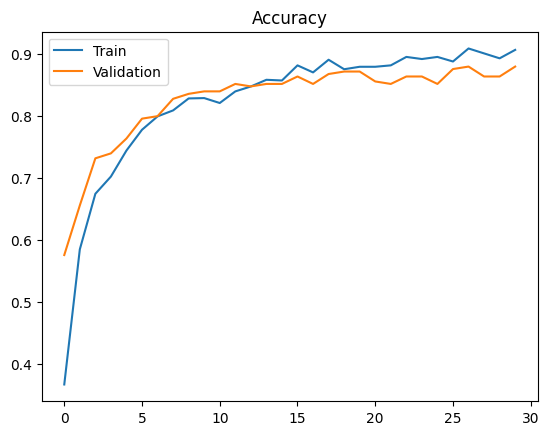

In [ ]:
# ---- LEARNING CURVES ----
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.legend(); plt.title("Accuracy")
plt.savefig(f"{OUTPUT_DIR}/accuracy_plot.png")

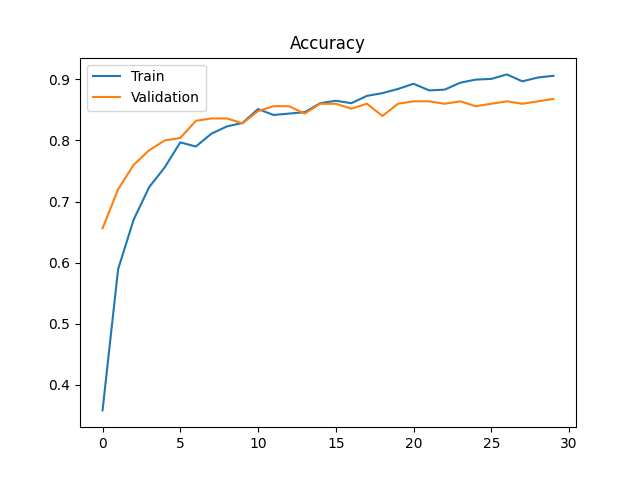

Grafik incelendiğinde:
- Eğitim doğruluğunun düzenli şekilde arttığı,
- Doğrulama doğruluğunun yaklaşık **%86–87** seviyelerinde dengelendiği,
- Modelin genelleme yeteneğinin güçlü olduğu görülmektedir.

## 5. Train ve Validation Loss Grafiği

In [ ]:
plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend(); plt.title("Loss")
plt.savefig(f"{OUTPUT_DIR}/loss_plot.png")

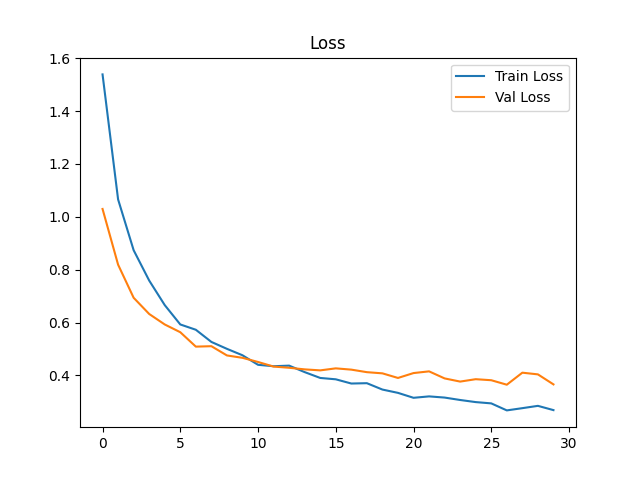

Loss grafiği incelendiğinde eğitim ve doğrulama kayıplarının
istikrarlı biçimde azaldığı görülmektedir.

Bu durum modelin aşırı öğrenmeye girmeden
başarılı bir şekilde eğitildiğini göstermektedir.

## 6. Test Veri Seti Üzerinde Performans Metrikleri

Modelin test veri seti üzerindeki performansı aşağıdaki metrikler
kullanılarak değerlendirilmiştir:
- Accuracy
- Balanced Accuracy
- Matthews Correlation Coefficient (MCC)
- Precision
- Recall
- F1 Score


In [ ]:
# ---- TEST EVALUATION ----
y_true, y_pred, y_prob = [], [], []

for x, y in test_ds:
    p = model.predict(x)
    y_prob.extend(p)
    y_pred.extend(np.argmax(p, axis=1))
    y_true.extend(y.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_prob = np.array(y_prob)

acc = accuracy_score(y_true, y_pred)
bacc = balanced_accuracy_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)
prec = precision_score(y_true, y_pred, average="macro")
rec = recall_score(y_true, y_pred, average="macro")
f1  = f1_score(y_true, y_pred, average="macro")

with open(f"{OUTPUT_DIR}/metrics_report.txt", "w") as f:
    f.write(f"Accuracy: {acc}\nBalanced Accuracy: {bacc}\nMCC: {mcc}\nPrecision: {prec}\nRecall: {rec}\nF1 Score: {f1}\n")
    f.write(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 

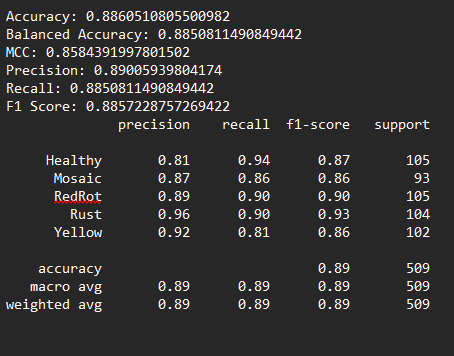

Elde edilen sonuçlar, modelin sınıflar arasında dengeli ve güvenilir
bir performans sergilediğini göstermektedir.

## 7. Test Verisi Karmaşıklık Matrisi (Confusion Matrix)

Karmaşıklık matrisi, modelin her bir sınıfı ne ölçüde doğru
sınıflandırdığını göstermektedir.


In [ ]:
# ---- CONFUSION MATRIX ----
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.savefig(f"{OUTPUT_DIR}/confusion_matrix.png")

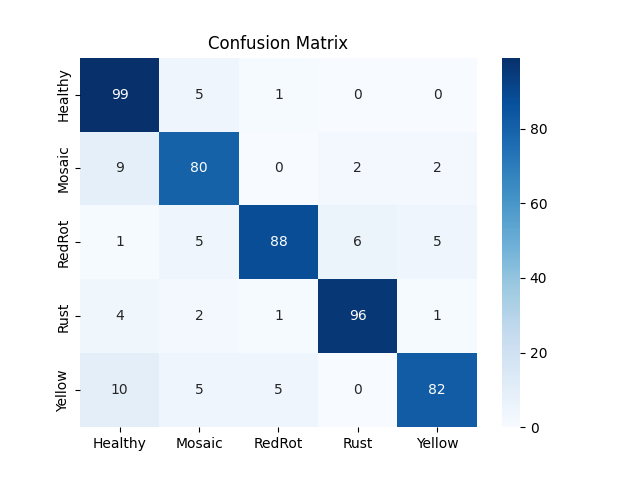

Ana diyagonal üzerindeki yüksek değerler,
modelin doğru sınıflandırma başarısının yüksek olduğunu göstermektedir.

## 8. ROC Eğrisi ve ROC AUC Analizi

ROC eğrisi, modelin farklı eşik değerlerinde
sınıfları ayırt etme başarısını göstermektedir.


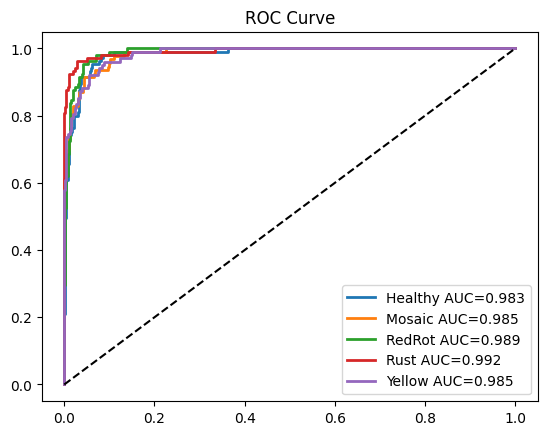

In [ ]:
# ---- ROC CURVE ----
y_true_bin = keras.utils.to_categorical(y_true, NUM_CLASSES)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

for i in range(NUM_CLASSES):
    plt.plot(fpr[i], tpr[i], lw=2, label=f"{class_names[i]} AUC={roc_auc[i]:.3f}")

plt.plot([0,1],[0,1],'k--')
plt.legend(); plt.title("ROC Curve")
plt.savefig(f"{OUTPUT_DIR}/roc_curve.png")


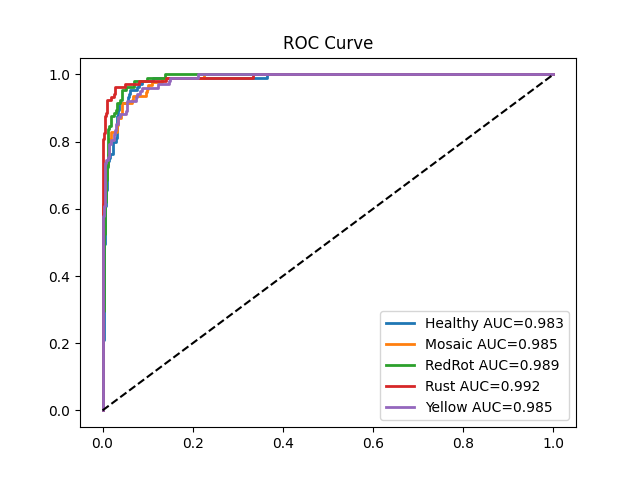

Hesaplanan ROC AUC değerlerinin 1’e yakın olması,
modelin sınıflar arası ayırt ediciliğinin oldukça yüksek olduğunu
göstermektedir.

## 9. Genel Değerlendirme

DenseNet121 modeli, test veri seti üzerinde yüksek doğruluk,
dengeli sınıflandırma ve güçlü genelleme performansı göstermiştir.
Transfer Learning yaklaşımı sayesinde model,
görüntü sınıflandırma problemi için başarılı bir çözüm sunmuştur.
